<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying them to our own problem.

* Pretrained model = foundation models

https://www.learnpytorch.io/06_pytorch_transfer_learning/



In [1]:
import torch
import torchvision

# nothing to do as these versions are fine;
# if you're using something real old you can
# look at the version numbers and !pip install
# the newer ones (see notebook 02)
print(torch.__version__) # 1.12+
print(torchvision.__version__) # 0.13+

1.13.0+cu116
0.14.0+cu116


Now that we're sure we have good versions of torch/torchvision, let's import the code from the previous section so we don't have to rewrite it.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/data .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3350, done.
remote: Total 3350 (delta 0), reused 0 (delta 0), pack-reused 3350
Receiving objects: 100% (3350/3350), 640.93 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (1921/1921), done.
Checking out files: 100% (221/221), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device is {device}. You {'need' if device == 'cpu' else 'do not need'} to restart your runtime to use gpu")

current device is cuda. You do not need to restart your runtime to use gpu


## 1. Get data

We need our pizza, steak sushi data to build a transfer learning model on.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_image_data(data_path_name: str = 'data',
                        image_path_name: str = 'pizza_steak_sushi',
                        zip_file_name: str = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
                        ):
  # Setup path to data folder
  data_path = Path(data_path_name)
  image_path = data_path / image_path_name

  # If the image folder doesn't exist, download it and prepare it... 
  if image_path.is_dir():
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)
      
      # Download pizza, steak, sushi data
      zipfile_path = (data_path / image_path_name).with_suffix('.zip')
      if not zipfile_path.is_file():
        with open(zipfile_path, "wb") as f:
            request = requests.get(zip_file_name)
            print("Downloading data...")
            f.write(request.content)

      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
          print("Unzipping data...") 
          zip_ref.extractall(image_path)

      # Remove .zip file
      os.remove(zipfile_path)
  return image_path

In [5]:
image_path = download_image_data(data_path_name='data',
                                 image_path_name='pizza_steak_sushi',
                                 zip_file_name='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
image_path
                    

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping data...


PosixPath('data/pizza_steak_sushi')

In [64]:
# Setup directory paths
data_path = Path('data')
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/04-pizza-dad.jpeg/train'),
 PosixPath('data/04-pizza-dad.jpeg/test'))

## 2. Create Datasets and DataLoaders

Now we've got data, turn it into DataLoaders. We can use `data_setup.py` and the `create_dataloaders` function.

There's one thing to think about when loading: how to **transform** it?

And with torchvision 0.13+ there's two ways to do this:

1. Manually created transforms.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` creates pretrained models (models ready for transfer learning) right within `torchvision`

In [7]:
from going_modular.going_modular.data_setup import create_dataloaders
from torchvision import transforms

# This is how you could make a manual transform that normalizes the
# data distributions for the previous PyTorch imagenet models:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir,
    transform=manual_transforms, # todo magic auto-transform
    batch_size=32)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 3, 224, 224])

### 2.2 Auto-creating a transform for `torchvision.models`

As of v0.13+ there's now support for automatic transform creation based on the pretrained model weights.

In [9]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms, auto_transforms.mean, auto_transforms.std

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir,
    transform=auto_transforms, # auto-transforms from weights
    batch_size=32)

## 3. Getting a pretrained model

There are various places to get a pretrained model:
1. PyTorch domain libraries
2. `timm` (torch image models)
3. HuggingFace Hub
4. paperswithcode.com


### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning is to take an already well-performing model from a problem space similar to your own and then customize it to your own problem.

Three things to consider:

1. Speed
2. Size
3. Performance

Where does the model live?

On device (car, phone...)?
On a server?

Looking at https://pytorch.org/vision/stable/models.html, which should we choose?

In this case (deploy foodvision mini on a mobile device), EfficientNetB0 is a good option for performance vs. size.

However, in light of [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html), if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.


### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0. https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html

In [12]:
# OLD method
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [14]:
# print a summary with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # batch size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pre-trained/foundation model and update the output layers to suit your own problem.

In [15]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False # no longer tracks the gradients; won't update with optimizer during training

summary(model=model,
        input_size=(1, 3, 224, 224), # batch size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [16]:
# update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector incoming
              out_features=len(class_names), bias=True)
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:

summary(model=model,
        input_size=(1, 3, 224, 224), # batch size, channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

start_time = timer()

# setup training and save results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=25,
                       device=device)

end_time = timer()
print(f'[INFO] total time: {end_time-start_time:.3f}seconds')
results

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.8984 | test_loss: 0.5715 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5457 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5250 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4390 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.4315 | train_acc: 0.9336 | test_loss: 0.4617 | test_acc: 0.8759
Epoch: 12 | train_l

{'train_loss': [1.0929433926939964,
  0.8702964335680008,
  0.7647756710648537,
  0.7114484086632729,
  0.6252278797328472,
  0.5770122520625591,
  0.5259467214345932,
  0.5249684117734432,
  0.5667422488331795,
  0.48466906696558,
  0.4314844235777855,
  0.4594263955950737,
  0.4248810485005379,
  0.3555406294763088,
  0.34335852786898613,
  0.36399383284151554,
  0.3187695052474737,
  0.32285044342279434,
  0.2895147167146206,
  0.41163836047053337,
  0.33476089872419834,
  0.3452733512967825,
  0.40397878363728523,
  0.31060634180903435,
  0.33457376062870026],
 'train_acc': [0.40234375,
  0.77734375,
  0.80078125,
  0.7578125,
  0.79296875,
  0.8984375,
  0.9140625,
  0.8046875,
  0.8125,
  0.81640625,
  0.93359375,
  0.82421875,
  0.9296875,
  0.9453125,
  0.96484375,
  0.9609375,
  0.9609375,
  0.96484375,
  0.96484375,
  0.85546875,
  0.94921875,
  0.84375,
  0.84375,
  0.84375,
  0.83203125],
 'test_loss': [0.9124558369318644,
  0.7900151014328003,
  0.7433415850003561,
  0.634

In [20]:
try:
  from helper_functions import plot_loss_curves
  print('failed')
except:
  print('[INFO] couldn\'t find helper_functions.py, downloading.')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py')
    f.write(request.content)
    from helper_functions import plot_loss_curves


[INFO] couldn't find helper_functions.py, downloading.


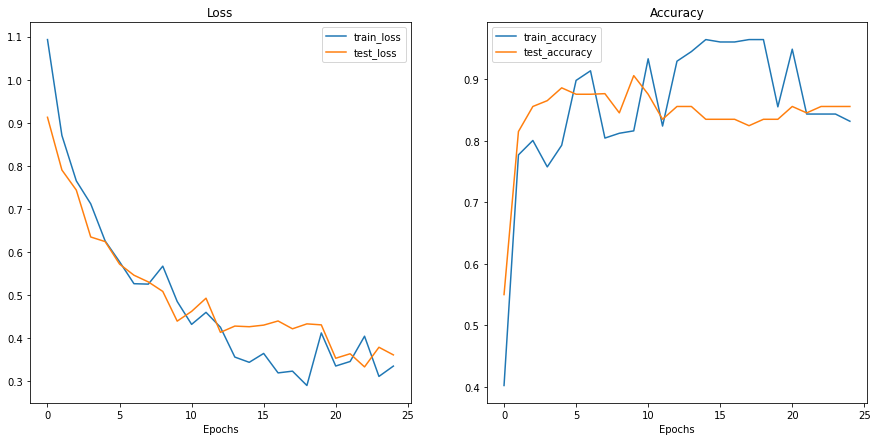

In [21]:
plot_loss_curves(results)

What do our loss curves look like in terms of the ideal loss curve?

## 6. Make predictions on images from the test set.

Visualize, visualize, visualize!

Make some qualitative predictions on the test set.

Some things to keep in mind when making predictions on test/custom data.

We have to make sure:
* Same shape - images need to be in same shape as training data.
* Same datatype - custom data should be the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - custom data should have the same transform going in as the training data on the foundation model.

To do all of this automagically, let's create a function called `pred_and_plot_image():

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device.
5. Make sure the data is on the same device, then turn the model to `model.eval()` mode for inference.
6. Transform the target image and make sure its dimensionality matches the model.
7. Make a prediction.
8. Convert the model's output to prediction probabilities via `torch.softmax()`
9. Convert the probabilities with `torch.argmax()`
10. Plot the image with `matplotlib` and set the title and prediction label from step 9 and prediction probability from step 8.

In [59]:
from typing import List, Tuple

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


# 1. Take in a trained model
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device=device,
    target_label=None):
  
  if not target_label:
    target_label = image_path.parent.stem

  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
  
  ### predict on image ***
  model.to(device)

  # 5. inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # adds the batch dimension: [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert output logits to prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert the pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Get the class name string
  classname = class_names[target_image_pred_label]

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  color = 'black' if classname == target_label else 'red'
  plt.title(f'Pred {classname} | Target: {target_label} | Prob {target_image_pred_probs.max():.3f}', color=color)
  plt.axis(False)


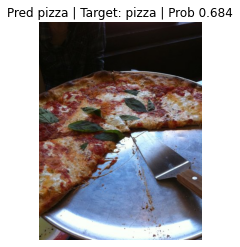

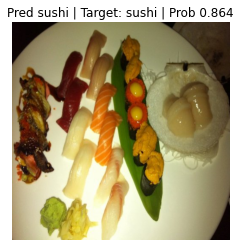

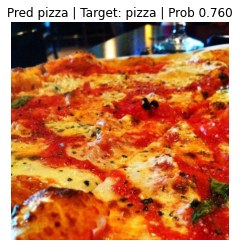

In [60]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))
                      

### 6.1 Custom image predictions!

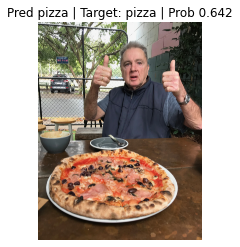

In [65]:
# Plot a custom image
image_path = data_path / '04-pizza-dad.jpeg'
pred_and_plot_image(model=model,
                    image_path=image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    target_label='pizza')

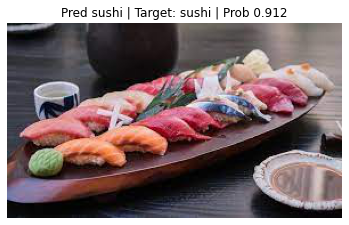

In [67]:
pred_and_plot_image(model=model,
                    image_path=data_path / 'my_sushi.jpeg',
                    class_names=class_names,
                    image_size=(224, 224),
                    target_label='sushi')

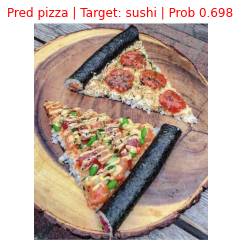

In [68]:
pred_and_plot_image(model=model,
                    image_path=data_path / 'sushipizza.jpeg',
                    class_names=class_names,
                    image_size=(224, 224),
                    target_label='sushi')

In [1]:
# vscode setup
# !curl -fsSL https://code-server.dev/install.sh | sh
# !pip install -qqq pyngrok
# from pyngrok import ngrok
# url = ngrok.connect(port=9000)
# print(f'url: {url}')
# !nohup code-server --port 9000 --auth none &
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
!nohup code-server --port 9000 --auth none &

nohup: appending output to 'nohup.out'


In [4]:
!mkdir /content/drive/MyDrive/vscode-ssh

In [5]:
!ls /content/drive/MyDrive/vscode-ssh

In [6]:
git_repo = 'https://github.com/gavindoughtie/pytorch_class'

In [7]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade --quiet
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared